This IMU model simulates the IMU intrinsic noise. However, vibration induced by aerodynamics can cause a bigger fluctuation. Test data from Neural Fly shows 
- amplitude of 1N in z, 0.5N in x and y residual force fluctuation, 0.08s peak to peak time.
- 0.01(rad/s or deg/s ? unit not provided). 0.08s peak to peak time 

Considering Neural Fly drone weight is 2.5kg, the vibration amplitude is around 0.4~0.8 m/s2

These noise could dominate the IMU intrinsic noise and is not yet considered in this IMU noise model. 

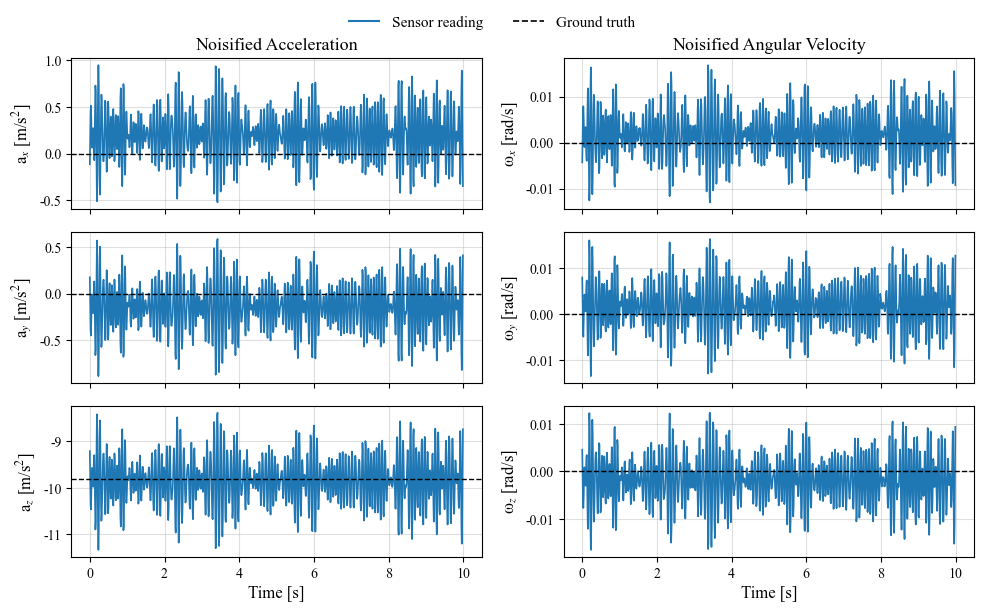

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import imu_model
import parameters as params
import utils

imu = imu_model.ImuModel()

can_save_fig_for_paper = True

tspan = np.arange(0, 10, 0.01)

ground_truth_accel = np.array([0.0, 0.0, params.Environment.g])
noisified_accel_profile = []
for t in tspan:
    noisified_accel = imu.create_noisified_accel(ground_truth_accel, t)
    noisified_accel_profile.append(noisified_accel)

noisified_accel_profile = np.vstack(noisified_accel_profile)

ground_truth_omega = np.array([0.0, 0.0, 0.0])
noisified_omega_profile = []
for t in tspan:
    noisified_omega = imu.create_noisified_omega(ground_truth_omega, t)
    noisified_omega_profile.append(noisified_omega)

noisified_omega_profile = np.vstack(noisified_omega_profile)

# for result in paper, flip signal from FRD to FLU
noisified_accel_profile = utils.FrdFluConverter.flip_vector(noisified_accel_profile.T).T
ground_truth_accel = utils.FrdFluConverter.flip_vector(ground_truth_accel)
noisified_omega_profile = utils.FrdFluConverter.flip_vector(noisified_omega_profile.T).T
ground_truth_omega = utils.FrdFluConverter.flip_vector(ground_truth_omega)

plt.rcParams.update({
    # ---- Use Times New Roman ----
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times"],
    "mathtext.fontset": "stix",
    "axes.unicode_minus": False,

    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

fig, axes = plt.subplots(3, 2, sharex=True, figsize=(10, 6))
axes = axes.ravel()

acc_labels = ['a$_x$ [m/s$^2$]', 'a$_y$ [m/s$^2$]', 'a$_z$ [m/s$^2$]']
omega_labels = ['ω$_x$ [rad/s]', 'ω$_y$ [rad/s]', 'ω$_z$ [rad/s]']

for i in range(3):
    l_idx = 2 * i
    r_idx = l_idx + 1

    # --- Acceleration (left column) ---
    axes[l_idx].plot(tspan, noisified_accel_profile[:, i], linewidth=1.2)
    axes[l_idx].axhline(
        ground_truth_accel[i], color='k', linestyle='--', linewidth=1.0,
        label='Ground truth' if i == 0 else ""
    )
    axes[l_idx].set_ylabel(acc_labels[i])
    axes[l_idx].grid(True, alpha=0.4)

    # --- Angular rate (right column) ---
    axes[r_idx].plot(tspan, noisified_omega_profile[:, i], linewidth=1.2)
    axes[r_idx].axhline(
        ground_truth_omega[i], color='k', linestyle='--', linewidth=1.0,
        label='Ground truth' if i == 0 else ""
    )
    axes[r_idx].set_ylabel(omega_labels[i])
    axes[r_idx].grid(True, alpha=0.4)

axes[-1].set_xlabel('Time [s]')
axes[-2].set_xlabel('Time [s]')

axes[0].set_title('Noisified Acceleration')
axes[1].set_title('Noisified Angular Velocity')

fig.legend(
    handles=[
        plt.Line2D([0], [0], color='C0', lw=1.5, label='Sensor reading'),
        plt.Line2D([0], [0], color='k', ls='--', lw=1.2, label='Ground truth')
    ],
    loc='upper center', ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.03)
)

plt.tight_layout()
plt.show()

if can_save_fig_for_paper: 
    filename = f"imu_reading_in_static.pdf"
    fig.savefig(filename, dpi=300, bbox_inches='tight')

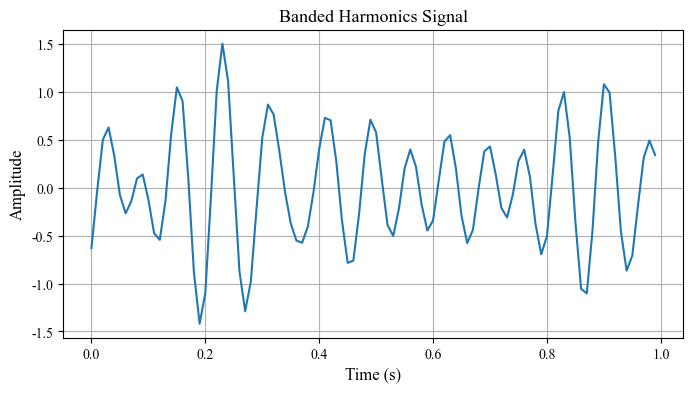

Mean: 0.0053353460092560945, RMS: 0.5934626908060291


In [2]:
banded_harmonics = imu_model.BandedHarmonics(10.0, 15.0, 100, 0.5)
signal = []
t_span = np.arange(0, 1, 0.01)
for t in t_span:
    signal.append(banded_harmonics.get_signal(t))

plt.figure(figsize=(8, 4))
plt.plot(t_span, signal)
plt.title('Banded Harmonics Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

mean = np.mean(signal)
rms = np.sqrt(np.mean((signal - mean)**2))
print(f"Mean: {mean}, RMS: {rms}")